# AML - Task 1

Predict the age of a brain from MRI features

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## Import data

In [2]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

X_test = pd.read_csv('data/X_test.csv')

## Data pre-processing

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Columns: 833 entries, id to x831
dtypes: float64(833)
memory usage: 7.7 MB


In [4]:
X_train.describe()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
count,1212.000000,1118.000000,1114.000000,1117.000000,1106.000000,1.117000e+03,1128.000000,1105.000000,1127.000000,1.116000e+03,...,1.134000e+03,1125.000000,1098.000000,1121.000000,1120.000000,1109.000000,1115.000000,1.112000e+03,1124.000000,1091.000000
mean,605.500000,10.026057,832442.859290,20585.524887,1048.958235,1.000291e+06,10.085010,597900.429955,10389.657239,9.998422e+05,...,1.049674e+06,-876.044006,13492.600186,10.554762,10.057767,1066.141107,10.008269,1.050199e+06,99798.480171,104903.905758
std,350.018571,0.968347,0.028258,0.029051,28.430733,9.740891e+04,0.968026,0.028128,1655.843472,1.022441e+05,...,2.839579e+04,164.585576,2519.835006,0.283844,0.982656,226.606986,1.018930,2.814210e+04,9576.128720,2768.405350
min,0.000000,6.672068,832442.808579,20585.473808,1000.063783,6.800215e+05,6.984052,597900.381003,3644.074892,6.095730e+05,...,1.000105e+06,-1597.766964,2536.030655,10.010366,6.841039,496.007706,6.466963,1.000002e+06,73207.994891,100012.896777
25%,302.750000,9.381273,832442.835941,20585.501013,1024.969967,9.360882e+05,9.470582,597900.406110,9339.537887,9.322937e+05,...,1.025054e+06,-975.398714,11947.954006,10.321039,9.379001,899.067501,9.325229,1.027575e+06,93416.252400,102596.190683
50%,605.500000,10.000079,832442.860041,20585.524817,1047.985497,1.000557e+06,10.089601,597900.429787,10295.013382,1.001261e+06,...,1.049296e+06,-875.508235,13352.186179,10.554260,10.114370,1049.027077,10.005684,1.050262e+06,99802.127899,104846.235709
75%,908.250000,10.664998,832442.882951,20585.550525,1073.180317,1.064617e+06,10.752707,597900.452983,11304.073469,1.068359e+06,...,1.074354e+06,-773.174562,14893.726023,10.792195,10.745370,1215.057985,10.658120,1.073831e+06,106400.748441,107098.669350
max,1211.000000,12.956099,832442.908334,20585.573514,1099.977638,1.331630e+06,12.747734,597900.480810,17347.531573,1.284804e+06,...,1.099771e+06,-281.030205,24815.260375,11.091050,13.530204,2122.032859,13.163113,1.099918e+06,130694.436443,109984.169649


In [ ]:
# X_train_profile = X_train.profile_report(
#     title="Report only Pearson",
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

In [ ]:
# X_train_profile.to_widgets()

### Outlier detection

AxesSubplot(0.125,0.125;0.775x0.755)


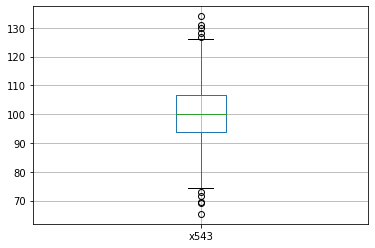

In [5]:
# Manually/visually look for outliers (e.g. x543), whiskers are at 1.5 IQR 
# (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html)
print(X_train.boxplot(column=['x543']))

#### IQR (Not conclusive)

In [ ]:
# Drop rows with any feature that is an outlier
# DROPS WAY TOO MANY ROWS, NEED OTHER STRATEGY (drop only outlier features, otw keeping the row? dangerous)
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

no_outliers = X_train[~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)]
no_outliers.describe()

#### Z-score

In [6]:
X_train_abs_z_scores = np.abs(zscore(X_train, nan_policy='omit'))
X_train = X_train[(X_train_abs_z_scores < 3)]

### Imputation of missing values

In [20]:
# Should test imputing with mean or k-nearest neighbours
# Use sklearn imputers and pipelines, cleaner than using pandas (I think, maybe? Since it's ML pipeline)
pipe = Pipeline([('imputer', KNNImputer()),
                 ('scaler', StandardScaler()), 
                 ('lasso', Lasso(alpha=0.1, max_iter=100000))])
pipe.fit(X_train.drop(columns=['id']), y_train.drop(columns=['id']))

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=100000))])

In [21]:
pipe.score(X_train.drop(columns=['id']), y_train.drop(columns=['id']))

0.710793441761512

In [22]:
result = pd.DataFrame(pipe.predict(X_test.drop(columns=['id'])))
result['id'] = range(len(result))
result = result.rename(columns={0: 'y'})
result = result[['id', 'y']]
result.to_csv('task1-sub1.csv', index=False)

### Feature selection

In [ ]:
# Should test either PCA or LASSO selection
# Irrelevant because highly correlated features w/ other features

### Normalise data (???)

In [ ]:
# Is it useful? (yes if linear model) Should we do it, do we lose something?
# Use sklearn pipelines, cleaner than using pandas (I think, maybe? Since it's ML pipeline)

## Training models

In [ ]:
# First try linear regression models, should make a baseline first and keep it
# Keeping the baseline is why we want to not touch the df with strategic choices
# of the ML pipeline that we might go back on and we should use sklearn's pipelines

## Writing submission

In [ ]:
# Use the best model to generate the solution